In [20]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import glob
import os
from ripple_heterogeneity.utils import functions
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'
functions.set_plotting_defaults()

## find data files

In [2]:

files = glob.glob(r"Z:/home/Heath/Viral_tracing/CTB/CTBR_anlaysis/**/*.csv",recursive=True)

dirnames = [os.path.dirname(file) for file in files]
dirnames = np.unique(dirnames)

## load data

In [3]:
df = pd.DataFrame()
for dirname in dirnames:
    layer_id = pd.read_csv(glob.glob(os.path.join(dirname,"*layerID.csv"))[0])

    red_cells_file = glob.glob(os.path.join(dirname,"*redcells.csv"))
    green_cells_file = glob.glob(os.path.join(dirname,"*greencells.csv"))
    colabel_cells_file = glob.glob(os.path.join(dirname,"*colabel.csv"))

    if len(red_cells_file) > 0:
        df_temp = pd.read_csv(red_cells_file[0])
        df_temp["color"] = "red"
        df_temp["folder_name"] = dirname
        df = pd.concat([df,df_temp],ignore_index=True)

    if len(green_cells_file) > 0:
        df_temp = pd.read_csv(green_cells_file[0])
        df_temp["color"] = "green"
        df_temp["folder_name"] = dirname
        df = pd.concat([df,df_temp],ignore_index=True)

    if len(colabel_cells_file) > 0:
        df_temp = pd.read_csv(colabel_cells_file[0])
        df_temp["color"] = "co_label"
        df_temp["folder_name"] = dirname
        df = pd.concat([df,df_temp],ignore_index=True)

    df.loc[df.folder_name == dirname,"layer_rad_y"] = layer_id.Y.iloc[0]
    df.loc[df.folder_name == dirname,"layer_or_y"] = layer_id.Y.iloc[1]

df["normalized_dist"] = np.abs(df.Y - df.layer_rad_y) / abs(df.layer_rad_y - df.layer_or_y)
df

,,Area,Mean,Min,Max,X,Y,Ch,Slice,color,folder_name,layer_rad_y,layer_or_y,normalized_dist
0,1,0.0,5642,5642,5642,136.640,99.204,1.0,13.0,red,Z:/home/Heath/Viral_tracing/CTB/CTBR_anlaysis\...,115.426,50.226,0.248804
1,2,0.0,3587,3587,3587,173.763,97.020,1.0,13.0,red,Z:/home/Heath/Viral_tracing/CTB/CTBR_anlaysis\...,115.426,50.226,0.282301
2,3,0.0,2674,2674,2674,253.002,106.379,1.0,13.0,red,Z:/home/Heath/Viral_tracing/CTB/CTBR_anlaysis\...,115.426,50.226,0.138758
3,4,0.0,5246,5246,5246,270.472,108.875,1.0,13.0,red,Z:/home/Heath/Viral_tracing/CTB/CTBR_anlaysis\...,115.426,50.226,0.100475
4,5,0.0,8924,8924,8924,103.260,89.533,1.0,13.0,red,Z:/home/Heath/Viral_tracing/CTB/CTBR_anlaysis\...,115.426,50.226,0.397132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,14,0.0,3731,3731,3731,63.640,317.133,1.0,5.0,green,Z:/home/Heath/Viral_tracing/CTB/CTBR_anlaysis\...,330.502,230.496,0.133682
2473,15,0.0,11987,11987,11987,379.169,277.558,1.0,3.0,green,Z:/home/Heath/Viral_tracing/CTB/CTBR_anlaysis\...,330.502,230.496,0.529408
2474,16,0.0,9293,9293,9293,30.483,302.158,1.0,3.0,green,Z:/home/Heath/Viral_tracing/CTB/CTBR_anlaysis\...,330.502,230.496,0.283423
2475,17,0.0,3894,3894,3894,310.715,245.470,1.0,2.0,green,Z:/home/Heath/Viral_tracing/CTB/CTBR_anlaysis\...,330.502,230.496,0.850269


## add rat ID

In [6]:
rats = ["CTBR1","CTBR2","CTBR3"]
for rat in rats:
    df.loc[df.folder_name.str.contains(rat),'rat_id'] = rat

## plot smoothed distribution of distances per projection type

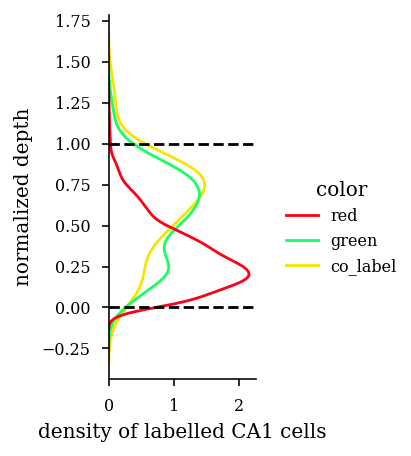

In [14]:
h,w = functions.set_size("thesis", fraction=.55, subplots=(1, 1))

group_colors = {"red": "#f9021a", "green": "#18ff5e","co_label":"#f7e400"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.displot(df, y="normalized_dist", hue="color",hue_order=group_colors, kind="kde", fill=False,common_norm=False,height=h,aspect=w/h,alpha=1)
plt.axhline(0,color="k",linestyle="--")
plt.axhline(1,color="k",linestyle="--")
plt.xlabel("density of labelled CA1 cells")
plt.ylabel("normalized depth")

plt.savefig(os.path.join(fig_save_path,'normalized_depth_labelled_ca1_cells.svg'),dpi=300,bbox_inches='tight')


## rank sum test between green and red distance

In [150]:
ranksums(df.query("color=='red'").normalized_dist,df.query("color=='green'").normalized_dist)

RanksumsResult(statistic=-14.169830824954143, pvalue=1.4083939049496847e-45)

## get proportions of cells 

In [151]:
prop_df = df.groupby("color").apply(lambda x: pd.Series({"n_cells":len(x)})).reset_index()
prop_df["prop"] = prop_df.n_cells / prop_df.n_cells.sum()
prop_df["constant"] = 1

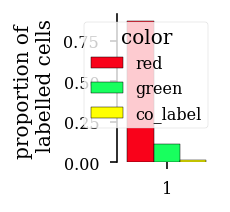

In [153]:
plt.figure(figsize = functions.set_size("thesis", fraction=.15, subplots=(2.5, 1)))

sns.barplot(data=prop_df,x="constant", hue="color", y="prop",hue_order=group_colors,edgecolor="k",saturation=1)
sns.despine(bottom=True)
plt.ylabel("proportion of \n labelled cells")
plt.xlabel("")
plt.savefig(os.path.join(fig_save_path,'prop_of_labelled_cells.svg'),dpi=300,bbox_inches='tight')


## make distribution plot for each animal

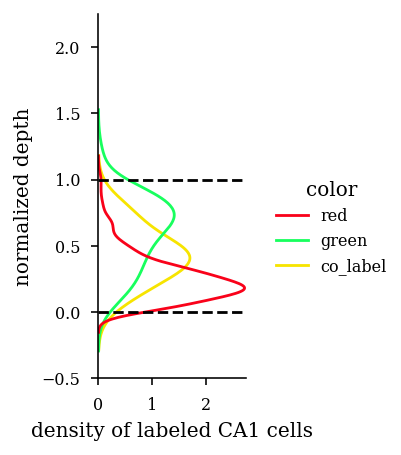

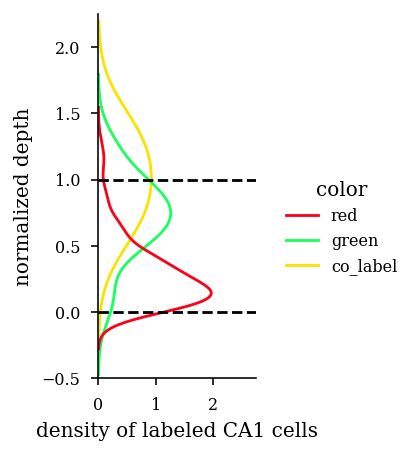

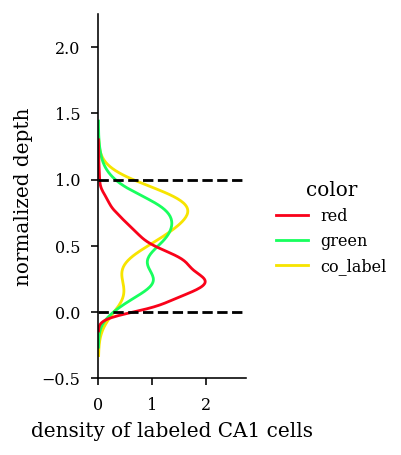

In [18]:
h,w = functions.set_size("thesis", fraction=.55, subplots=(1, 1))
group_colors = {"red": "#f9021a", "green": "#18ff5e","co_label":"#f7e400"}
sns.set_palette(sns.color_palette(group_colors.values()))
sns.displot(df.query("rat_id=='CTBR1'"), y="normalized_dist", hue="color",hue_order=group_colors, kind="kde", fill=False,common_norm=False,height=h,aspect=w/h,alpha=1)
plt.axhline(0,color="k",linestyle="--")
plt.axhline(1,color="k",linestyle="--")
plt.xlabel("density of labeled CA1 cells")
plt.ylabel("normalized depth")
plt.ylim(-0.5,2.25)
plt.xlim(0,2.75)
plt.savefig(os.path.join(fig_save_path,'normalized_depth_labelled_ca1_cells_CTBR1.svg'),dpi=300,bbox_inches='tight')

h,w = functions.set_size("thesis", fraction=.55, subplots=(1, 1))
group_colors = {"red": "#f9021a", "green": "#18ff5e","co_label":"#f7e400"}
sns.set_palette(sns.color_palette(group_colors.values()))
sns.displot(df.query("rat_id=='CTBR2'"), y="normalized_dist", hue="color",hue_order=group_colors, kind="kde", fill=False,common_norm=False,height=h,aspect=w/h,alpha=1)
plt.axhline(0,color="k",linestyle="--")
plt.axhline(1,color="k",linestyle="--")
plt.xlabel("density of labeled CA1 cells")
plt.ylabel("normalized depth")
plt.ylim(-0.5,2.25)
plt.xlim(0,2.75)
plt.savefig(os.path.join(fig_save_path,'normalized_depth_labelled_ca1_cells_CTBR2.svg'),dpi=300,bbox_inches='tight')

h,w = functions.set_size("thesis", fraction=.55, subplots=(1, 1))
group_colors = {"red": "#f9021a", "green": "#18ff5e","co_label":"#f7e400"}
sns.set_palette(sns.color_palette(group_colors.values()))
sns.displot(df.query("rat_id=='CTBR3'"), y="normalized_dist", hue="color",hue_order=group_colors, kind="kde", fill=False,common_norm=False,height=h,aspect=w/h,alpha=1)
plt.axhline(0,color="k",linestyle="--")
plt.axhline(1,color="k",linestyle="--")
plt.xlabel("density of labeled CA1 cells")
plt.ylabel("normalized depth")
plt.ylim(-0.5,2.25)
plt.xlim(0,2.75)
plt.savefig(os.path.join(fig_save_path,'normalized_depth_labelled_ca1_cells_CTBR3.svg'),dpi=300,bbox_inches='tight')


In [21]:
ranksums(df.query("rat_id=='CTBR1' & color=='red'").normalized_dist,df.query("rat_id=='CTBR1' & color=='green'").normalized_dist)

RanksumsResult(statistic=-8.237780568557714, pvalue=1.7543456032975933e-16)

In [22]:
ranksums(df.query("rat_id=='CTBR2' & color=='red'").normalized_dist,df.query("rat_id=='CTBR2' & color=='green'").normalized_dist)

RanksumsResult(statistic=-4.99614677107664, pvalue=5.848715378855456e-07)

In [23]:
ranksums(df.query("rat_id=='CTBR3' & color=='red'").normalized_dist,df.query("rat_id=='CTBR3' & color=='green'").normalized_dist)

RanksumsResult(statistic=-10.309591073168994, pvalue=6.37720888507043e-25)

In [25]:
df[["rat_id","color"]].value_counts()

rat_id  color   
CTBR3   red         1490
CTBR1   red          525
CTBR3   green        209
CTBR2   red          152
CTBR1   green         51
CTBR3   co_label      23
CTBR2   green         19
CTBR1   co_label       6
CTBR2   co_label       2
dtype: int64

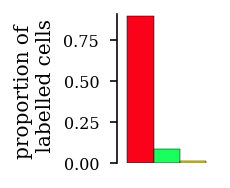

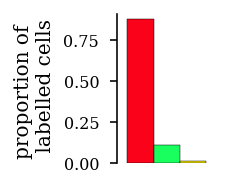

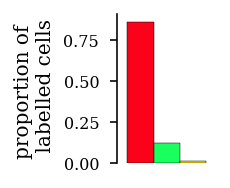

In [40]:
prop_df = df.query("rat_id=='CTBR1'").groupby("color").apply(lambda x: pd.Series({"n_cells":len(x)})).reset_index()
prop_df["prop"] = prop_df.n_cells / prop_df.n_cells.sum()
prop_df["constant"] = 1
plt.figure(figsize = functions.set_size("thesis", fraction=.15, subplots=(2.5, 1)))
sns.barplot(data=prop_df,x="constant", hue="color", y="prop",hue_order=group_colors,edgecolor="k",saturation=1)
sns.despine(bottom=True)
plt.ylabel("proportion of \n labelled cells")
plt.xlabel("")
plt.ylim(0,.91)
plt.gca().get_legend().remove()
plt.gca().axes.get_xaxis().set_visible(False)
plt.savefig(os.path.join(fig_save_path,'prop_of_labelled_cells_CTBR1.svg'),dpi=300,bbox_inches='tight')

prop_df = df.query("rat_id=='CTBR2'").groupby("color").apply(lambda x: pd.Series({"n_cells":len(x)})).reset_index()
prop_df["prop"] = prop_df.n_cells / prop_df.n_cells.sum()
prop_df["constant"] = 1
plt.figure(figsize = functions.set_size("thesis", fraction=.15, subplots=(2.5, 1)))
sns.barplot(data=prop_df,x="constant", hue="color", y="prop",hue_order=group_colors,edgecolor="k",saturation=1)
sns.despine(bottom=True)
plt.ylabel("proportion of \n labelled cells")
plt.xlabel("")
plt.ylim(0,.91)
plt.gca().get_legend().remove()
plt.gca().axes.get_xaxis().set_visible(False)
plt.savefig(os.path.join(fig_save_path,'prop_of_labelled_cells_CTBR2.svg'),dpi=300,bbox_inches='tight')

prop_df = df.query("rat_id=='CTBR3'").groupby("color").apply(lambda x: pd.Series({"n_cells":len(x)})).reset_index()
prop_df["prop"] = prop_df.n_cells / prop_df.n_cells.sum()
prop_df["constant"] = 1
plt.figure(figsize = functions.set_size("thesis", fraction=.15, subplots=(2.5, 1)))
sns.barplot(data=prop_df,x="constant", hue="color", y="prop",hue_order=group_colors,edgecolor="k",saturation=1)
sns.despine(bottom=True)
plt.ylabel("proportion of \n labelled cells")
plt.xlabel("")
plt.ylim(0,.91)
plt.gca().get_legend().remove()
plt.gca().axes.get_xaxis().set_visible(False)
plt.savefig(os.path.join(fig_save_path,'prop_of_labelled_cells_CTBR3.svg'),dpi=300,bbox_inches='tight')


In [38]:
prop_df = df.query("rat_id=='CTBR1'").groupby("color").apply(lambda x: pd.Series({"n_cells":len(x)})).reset_index()
prop_df["prop"] = prop_df.n_cells / prop_df.n_cells.sum()
prop_df["constant"] = 1
display(prop_df)

prop_df = df.query("rat_id=='CTBR2'").groupby("color").apply(lambda x: pd.Series({"n_cells":len(x)})).reset_index()
prop_df["prop"] = prop_df.n_cells / prop_df.n_cells.sum()
prop_df["constant"] = 1
display(prop_df)

prop_df = df.query("rat_id=='CTBR3'").groupby("color").apply(lambda x: pd.Series({"n_cells":len(x)})).reset_index()
prop_df["prop"] = prop_df.n_cells / prop_df.n_cells.sum()
prop_df["constant"] = 1
display(prop_df)

,color,n_cells,prop,constant
0,co_label,6,0.010309,1
1,green,51,0.087629,1
2,red,525,0.902062,1


,color,n_cells,prop,constant
0,co_label,2,0.011561,1
1,green,19,0.109827,1
2,red,152,0.878613,1


,color,n_cells,prop,constant
0,co_label,23,0.013357,1
1,green,209,0.121370,1
2,red,1490,0.865273,1
